# Model Second Pass

Within this section I'll re-evaluate the data we adjusted in the last section. This new dataset contains changes made after the first pass of our model, which identified several severe outliers. These outliers have been verified or removed from the dataset.

### Library Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time

import pycaret
from pycaret.regression import *
from pycaret.regression import RegressionExperiment
from pycaret.regression import save_model, load_model

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

from itertools import combinations
from sklearn.inspection import permutation_importance

In [2]:
pd.set_option('display.max_columns', None)

### Dataframe Import

In [3]:
with open('pickles/df_adj.pkl', 'rb') as f:
    df_adj = pickle.load(f)
with open('pickles/combined_metrics.pkl', 'rb') as f:
    combined_metrics = pickle.load(f)

In [4]:
df_model= df_adj

### Creating Model df

Since many of the features in our df are not necessary, or useful, in the modelling process, I'll create a new dataframe that contains all of the features I'm interested as using within the model.

In [6]:
df_model.head(5)

start_year  end_year  rr?  overhead?  anglo train_type project_type  \
1         2001      2005  0.0          0      0        MRT          New   
2         1986      1989  0.0          1      0        MRT    Extension   
8         1978      1982  0.0          0      0        MRT    Extension   
10        2011      2016  0.0          0      0        MRT          New   
13        1981      1986  0.0          0      0        MRT    Extension   

   region    sub_region  wrb_class_value  prob_Ferralsols  prob_Acrisols  \
1    Asia  Eastern Asia              0.0             13.0           37.0   
2    Asia  Eastern Asia              0.0             13.0           37.0   
8    Asia  Eastern Asia              0.0             13.0           37.0   
10   Asia  Eastern Asia              0.0             13.0           37.0   
13   Asia  Eastern Asia              0.0             13.0           37.0   

    prob_Andosols  prob_Cryosols  prob_Cambisols  prob_Gleysols  \
1             4.0            0.0            15.0            3.0   
2             4.0            0.0            15.0            3.0   
8             4.0            0.0            15.0            3.0   
10            4.0            0.0            15.0            3.0   
13            4.0            0.0            15.0            3.0   

    prob_Kastanozems  prob_Albeluvisols  prob_Calcisols  prob_Chernozems  \
1                0.0                0.0             0.0              0.0   
2                0.0                0.0             0.0              0.0   
8                0.0                0.0             0.0              0.0   
10               0.0                0.0             0.0              0.0   
13               0.0                0.0             0.0              0.0   

    prob_Durisols  prob_Gypsisols  prob_Fluvisols  prob_Alisols  \
1             0.0             0.0             4.0           3.0   
2             0.0             0.0             4.0           3.0   
8             0.0             0.0             4.0           3.0   
10            0.0             0.0             4.0           3.0   
13            0.0             0.0             4.0           3.0   

    prob_Planosols  prob_Arenosols  prob_Plinthosols  prob_Luvisols  \
1              0.0             0.0               0.0            5.0   
2              0.0             0.0               0.0            5.0   
8              0.0             0.0               0.0            5.0   
10             0.0             0.0               0.0            5.0   
13             0.0             0.0               0.0            5.0   

    prob_Umbrisols  prob_Podzols  prob_Histosols  prob_Vertisols  \
1              0.0           1.0             1.0             1.0   
2              0.0           1.0             1.0             1.0   
8              0.0           1.0             1.0             1.0   
10             0.0           1.0             1.0             1.0   
13             0.0           1.0             1.0             1.0   

    prob_Lixisols  prob_Phaeozems  prob_Regosols  prob_Solonetz  \
1             4.0             0.0            0.0            0.0   
2             4.0             0.0            0.0            0.0   
8             4.0             0.0            0.0            0.0   
10            4.0             0.0            0.0            0.0   
13            4.0             0.0            0.0            0.0   

    prob_Solonchaks  prob_Leptosols  prob_Nitisols  prob_Stagnosols  tavg  \
1               0.0             3.0            3.0              0.0  23.5   
2               0.0             3.0            3.0              0.0  23.5   
8               0.0             3.0            3.0              0.0  23.5   
10              0.0             3.0            3.0              0.0  23.5   
13              0.0             3.0            3.0              0.0  23.5   

    tmin  tmax  price_income_ratio  urban?  price_rent_ratio  \
1   21.6  26.0                   6       1                 8   
2  

In [7]:
def convert_str_to_float(val):
    if isinstance(val, str):
        return float(val.replace(',', ''))
    return val

cols_to_exclude = ['region', 'sub_region','train_type','project_type']
df_model.loc[:, ~df_model.columns.isin(cols_to_exclude)] = df_model.loc[:, ~df_model.columns.isin(cols_to_exclude)].applymap(convert_str_to_float)

In [8]:
cont_feats = df_model.drop(columns=['region', 'sub_region','wrb_class_value','cost_real_2023_transformed','train_type','project_type']).columns.tolist()
cat_feats = ['region', 'sub_region', 'train_type', 'wrb_class_value','urban?','project_type']
ordinal_feats = ['wrb_class_value']

### Generating Unseen Data (test)

In [9]:
data = df_model.sample(frac=0.8, random_state=786)
data_unseen = df_model.drop(data.index)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1058, 68)
Unseen Data For Predictions: (265, 68)


### PyCaret Setup

In [10]:
s = setup(data,
          target = 'cost_real_2023_transformed',
          ordinal_features ={'wrb_class_value': list(range(0, 30))},
          categorical_features= cat_feats,
          numeric_features= cont_feats,
          normalize = True,
          normalize_method = 'zscore',
          verbose = False,
          feature_selection = False,
          low_variance_threshold = 0.1,
          pca = False, 
          pca_components = 30,
          remove_multicollinearity = False,
          multicollinearity_threshold = 0.3
         )

In [11]:
transformed_data = get_config('X_train')
transformed_data

start_year  end_year  rr?  overhead?  anglo  train_type project_type  \
134         2010      2017  0.0          1      0   Streetcar          New   
70          2010      2012  0.0          1      0   Streetcar          New   
1288        2008      2013  0.0          1      1  Light Rail    Extension   
725         2020      2025  0.0          0      1         MRT    Extension   
108         2003      2008  0.0          0      0         MRT          New   
...          ...       ...  ...        ...    ...         ...          ...   
237         2021      2030  0.0          0      0         MRT          New   
935         2024      2027  0.0          0      0         MRT    Extension   
1331        2000      2009  0.0          1      0  Light Rail          New   
578         2010      2014  0.0          0      0         MRT          New   
480         2021      2025  0.0          1      0         MRT    Extension   

        region          sub_region  wrb_class_value  prob_Ferralsols  \
134     Europe      Western Europe             18.0              0.0   
70      Europe      Western Europe             11.0              0.0   
1288  Americas    Northern America             15.0              0.0   
725   Americas    Northern America              6.0              0.0   
108     Europe      Western Europe              6.0              0.0   
...        ...                 ...              ...              ...   
237     Europe      Western Europe              6.0              0.0   
935       Asia  South-eastern Asia             11.0              2.0   
1331    Europe     Southern Europe              6.0              0.0   
578       Asia        Eastern Asia             11.0              0.0   
480       Asia        Eastern Asia             11.0              0.0   

      prob_Acrisols  prob_Andosols  prob_Cryosols  prob_Cambisols  \
134             2.0            0.0            0.0            11.0   
70              3.0            0.0            0.0            21.0   
1288            0.0            0.0            0.0            23.0   
725             2.0            3.0            0.0            35.0   
108             0.0            2.0            0.0            20.0   
...             ...            ...            ...             ...   
237             0.0            1.0            0.0            22.0   
935             0.0            0.0            0.0             9.0   
1331            1.0            0.0            0.0            26.0   
578             3.0            2.0            0.0            23.0   
480             2.0            0.0            0.0             9.0   

      prob_Gleysols  prob_Kastanozems  prob_Albeluvisols  prob_Calcisols  \
134             6.0               2.0                0.0            12.0   
70              6.0               4.0                2.0             1.0   
1288            0.0              33.0                0.0             5.0   
725             5.0               4.0                0.0             0.0   
108             5.0               4.0                2.0             3.0   
...             ...               ...                ...             ...   
237            10.0               1.0                1.0             2.0   
935             3.0               1.0                0.0             2.0   
1331            2.0               7.0                0.0             0.0   
578            26.0               0.0                0.0             0.0   
480             5.0               0.0                0.0             1.0   

      prob_Chernozems  prob_Durisols  prob_Gypsisols  prob_Fluvisols  \
134               4.0            0.0             2.0             9.0   
70                1.0            0.0             0.0            22.0   
1288              5.0            0.0             2.0             7.0   
725               0.0            0.0             0.0             4.0   
108               6.0            0.0             1.0             8.0   
...               ...         

In [12]:
compare_models(exclude = ['lar','lr'])

Processing:   0%|          | 0/77 [00:00<?, ?it/s]

It's important to note that the purpose of the follwing iterative portion of my analysis is not to improve the R-squared or to necessarily reduce the error metrics, it was to mitigate the influence of outliers that were not indicitive of transit projects as a whole. There will always be a transit project that is odd or unique that will be difficult to approximate, the goal of this model is to provide a baseline estimate for a transit project given some basic information.

### Polynomial Features

Based on the findings in the Non-Linear Trends section, the model may benefit from applying an exponent to important features.

I'll summarize the steps below and then re-run the model.

In [13]:
train_type_dummies = pd.get_dummies(df_model['train_type'], prefix='train_type')
df_encoded = pd.concat([df_adj, train_type_dummies], axis=1)

In [14]:
features = ['tunnel_transformed', 'elevated_transformed', 'duration_transformed'] + list(train_type_dummies.columns)
correlation_results = pd.DataFrame(columns=['Feature', 'Pearson', 'Spearman'])

In [15]:
for feature in features:
    pearson_corr = df_encoded[feature].corr(df_encoded['cost_real_2023_transformed'], method='pearson')
    spearman_corr = df_encoded[feature].corr(df_encoded['cost_real_2023_transformed'], method='spearman')
    correlation_results = correlation_results.append({
        'Feature': feature,
        'Pearson': pearson_corr,
        'Spearman': spearman_corr
    }, ignore_index=True)

correlation_results

Feature   Pearson  Spearman
0       tunnel_transformed  0.731164  0.759699
1     elevated_transformed  0.320591  0.316600
2     duration_transformed  0.417184  0.403422
3    train_type_Light Rail -0.162992 -0.173245
4           train_type_MRT  0.584085  0.589389
5  train_type_Monorail/APM -0.097846 -0.094811
6     train_type_Streetcar -0.530732 -0.529028

Now Let's re-run the model to see if we've improved the result at all.

In [16]:
data = df_model.sample(frac=0.8, random_state=786)
data_unseen = df_model.drop(data.index)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1058, 68)
Unseen Data For Predictions: (265, 68)


In [17]:
data.columns

Index(['start_year', 'end_year', 'rr?', 'overhead?', 'anglo', 'train_type',
       'project_type', 'region', 'sub_region', 'wrb_class_value',
       'prob_Ferralsols', 'prob_Acrisols', 'prob_Andosols', 'prob_Cryosols',
       'prob_Cambisols', 'prob_Gleysols', 'prob_Kastanozems',
       'prob_Albeluvisols', 'prob_Calcisols', 'prob_Chernozems',
       'prob_Durisols', 'prob_Gypsisols', 'prob_Fluvisols', 'prob_Alisols',
       'prob_Planosols', 'prob_Arenosols', 'prob_Plinthosols', 'prob_Luvisols',
       'prob_Umbrisols', 'prob_Podzols', 'prob_Histosols', 'prob_Vertisols',
       'prob_Lixisols', 'prob_Phaeozems', 'prob_Regosols', 'prob_Solonetz',
       'prob_Solonchaks', 'prob_Leptosols', 'prob_Nitisols', 'prob_Stagnosols',
       'tavg', 'tmin', 'tmax', 'price_income_ratio', 'urban?',
       'price_rent_ratio', 'city_density_transformed',
       'stations_per_km_transformed', 'country_pop_den_transformed',
       'mortgage_perc_income_transformed', 'elevation_transformed',
       'at

In [18]:
cont_feats = df_model.drop(columns=['region', 'sub_region','wrb_class_value','cost_real_2023_transformed','train_type','project_type']).columns.tolist()
cat_feats = ['region', 'sub_region', 'train_type', 'wrb_class_value','urban?','project_type']
ordinal_feats = ['wrb_class_value']

In [19]:
s = setup(data,
          target = 'cost_real_2023_transformed',
          ordinal_features ={'wrb_class_value': list(range(0, 30))},
          categorical_features= cat_feats,
          numeric_features= cont_feats,
          normalize = True,
          normalize_method = 'zscore',
          verbose = False,
          feature_selection = False,
          low_variance_threshold = 0.1,
          pca = False, 
          pca_components = 30,
          remove_multicollinearity = False,
          multicollinearity_threshold = 0.3,
          fold=10
         )

In [20]:
compare_models(exclude = ['lar','lr'])

Processing:   0%|          | 0/77 [00:00<?, ?it/s]

### Model Tuning

Let's take the best model that were generated above and tune the parameters. The 'compare' function in PyCaret creates a baseline score for each type of algorithm, but it doesn't optimize any algorithm for the specific data it's iterating over.

This section will output an optimized model that performs better than the baseline model discussed above. Additionally, I'll investigate ways to limit the overfitting of my model.

#### Random Forest (rf)

In [21]:
rf = create_model('rf')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

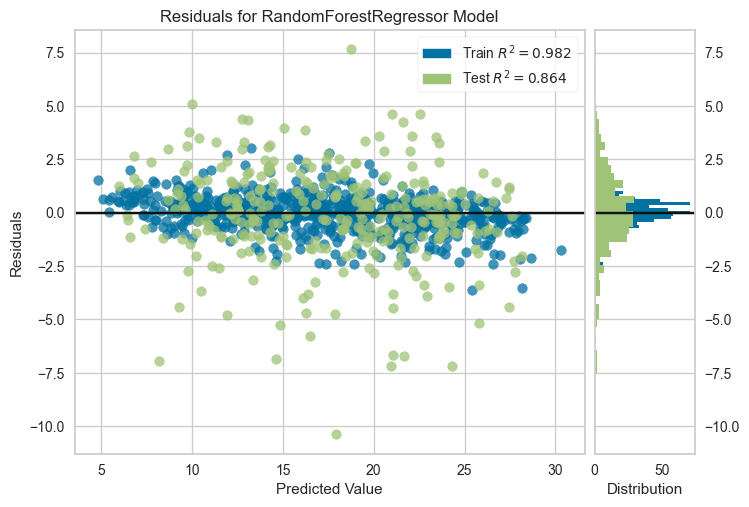

In [22]:
plot_model(rf, plot = 'residuals')

In [23]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300,400,500,600,700,800,900,1000],
    'max_depth': [None, 3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2'],
}

In [24]:
rf_tuned = tune_model(
    rf,
    fold = 10,
    n_iter = 100,
    custom_grid = param_grid_rf,
    choose_better = False,
    optimize='R2'
)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


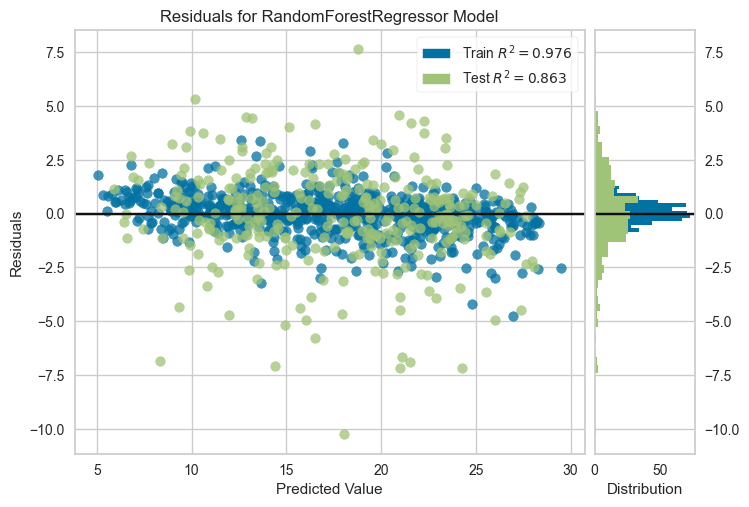

In [25]:
plot_model(rf_tuned, plot = 'residuals')

In [26]:
predictions = predict_model(rf_tuned, data=data_unseen)

#### ExtraTrees Regressor (et)

This model performed well, but was prone to (drastic) overfitting.

In [27]:
et = create_model('et')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

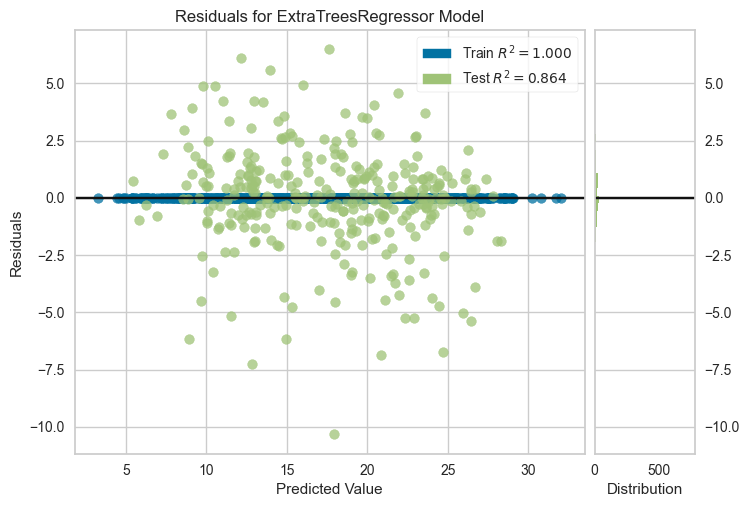

In [28]:
plot_model(et, plot = 'residuals')

In [29]:
param_grid_et = {
    'n_estimators': [50, 100, 200, 300,400,500,600,700,1000],
    'max_depth': [None, 3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [30]:
et_tuned = tune_model(
    et,
    fold = 10,
    n_iter = 50,
    custom_grid = param_grid_et,
    choose_better = False,
    optimize='R2'
)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


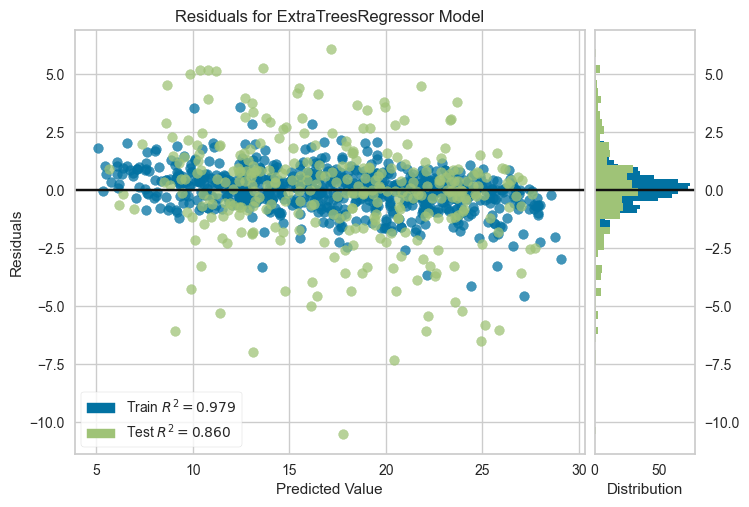

In [31]:
plot_model(et_tuned, plot = 'residuals')

In [32]:
predictions = predict_model(et_tuned, data=data_unseen)

#### Bayesian Ridge

In [33]:
br = create_model('br')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

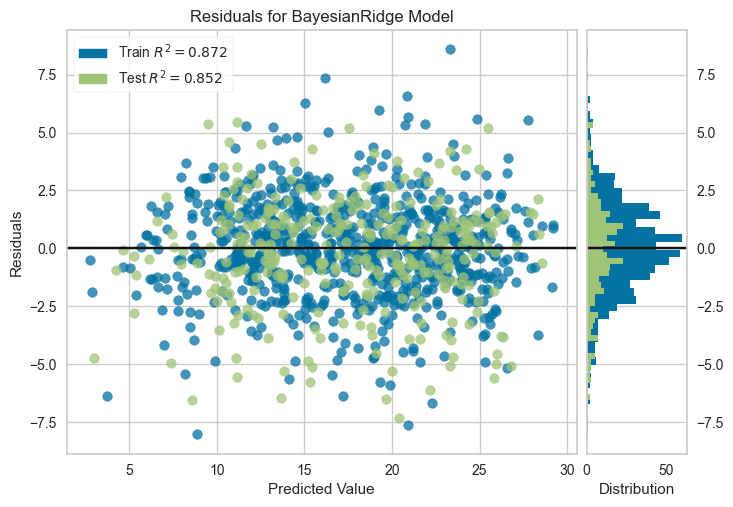

In [34]:
plot_model(br, plot = 'residuals')

In [35]:
param_grid_br = {
    'n_iter': [100, 200, 300, 500,600,700,800,900,1000],  
    'tol': [1e-3, 1e-4, 1e-5],  
    'alpha_1': [1e-6, 1e-5, 1e-4],  
    'alpha_2': [1e-6, 1e-5, 1e-4],  
    'lambda_1': [1e-6, 1e-5, 1e-4],  
    'lambda_2': [1e-6, 1e-5, 1e-4],  
    'alpha_init': [None, 1e-2, 1e-1, 1],  
    'lambda_init': [None, 1e-2, 1e-1, 1],  
    'fit_intercept': [True, False], 
    'compute_score': [True, False],  
    'copy_X': [True, False],
}

In [36]:
br_tuned = tune_model(
    br,
    fold = 10,
    n_iter = 100,
    custom_grid = param_grid_br,
    choose_better = False,
    optimize='R2'
)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


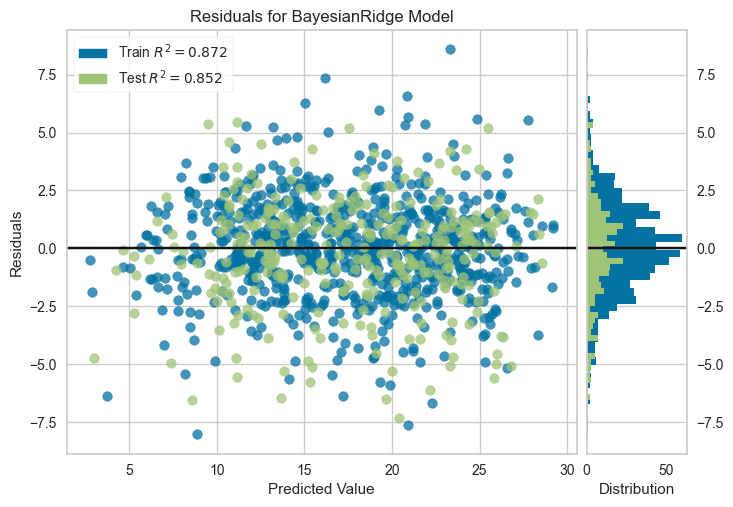

In [37]:
plot_model(br_tuned, plot = 'residuals')

In [38]:
predictions = predict_model(br_tuned, data=data_unseen)

#### Elastic Net

In [39]:
en = create_model('en')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

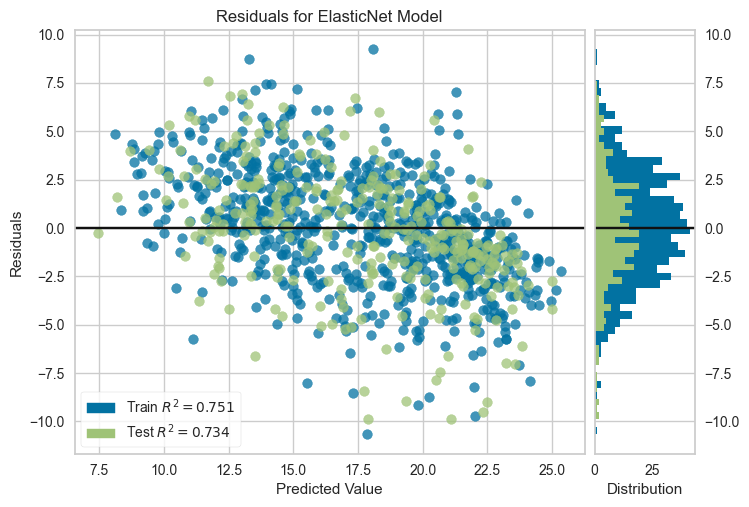

In [40]:
plot_model(en, plot = 'residuals')

In [41]:
param_grid_en = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': np.arange(0.0, 1.1, 0.1),
    'fit_intercept': [True, False],
    'precompute': [True, False],
    'max_iter': [500,1000, 1500, 2000,2500,3000],
    'copy_X': [True, False],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'warm_start': [True, False],
    'positive': [True, False],
    'random_state': [0, 42],
    'selection': ['cyclic', 'random']
}

In [42]:
en_tuned = tune_model(
    en,
    fold = 10,
    n_iter = 100,
    custom_grid = param_grid_en,
    choose_better = False, 
    optimize='R2'
)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


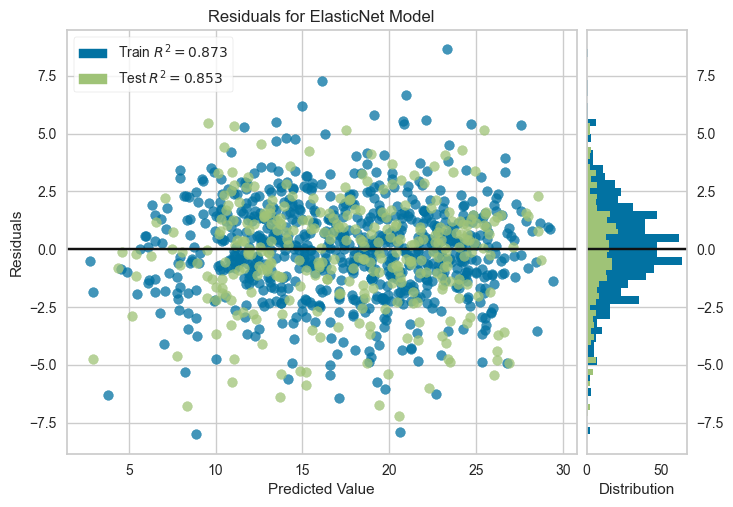

In [43]:
plot_model(en_tuned, plot = 'residuals')

In [44]:
predictions = predict_model(en_tuned, data=data_unseen)

#### XGBoost

In [45]:
xg = create_model('xgboost')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

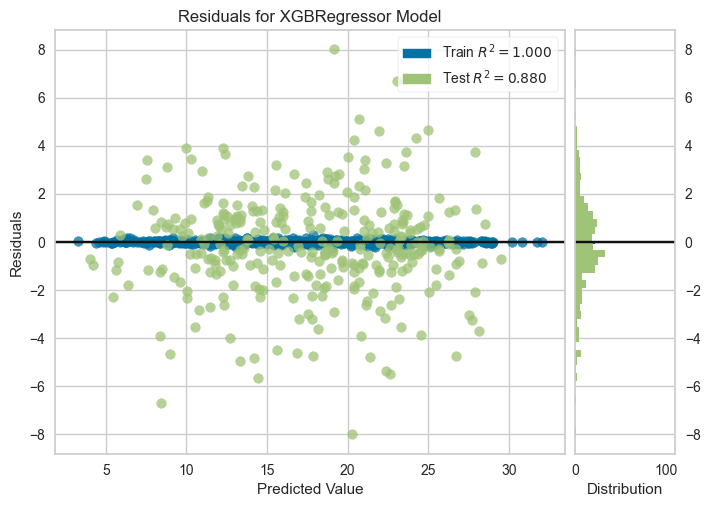

In [46]:
plot_model(xg, plot = 'residuals')

In [47]:
param_grid_xg = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'max_depth': [3, 4, 5, 6, 7, 8, 10],  
    'min_child_weight': [1, 2, 5, 10],  
    'subsample': [0.5, 0.7, 0.9, 1.0],  
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],  
    'n_estimators': [50, 100, 200, 300,400,500,600,700,800],  
    'objective': ['reg:squarederror', 'binary:logistic', 'multi:softmax'],  
    'gamma': [0, 0.25, 0.5, 1.0],  
    'reg_lambda': [0.1, 1.0, 5.0, 10.0],  # L2 regularization weights.
    'reg_alpha': [0.1, 1.0, 5.0, 10.0],  # L1 regularization weights.
}

In [48]:
xg_tuned = tune_model(
    xg,
    fold = 10,
    n_iter = 100,
    custom_grid = param_grid_xg,
    choose_better = False,
    optimize='R2'
)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


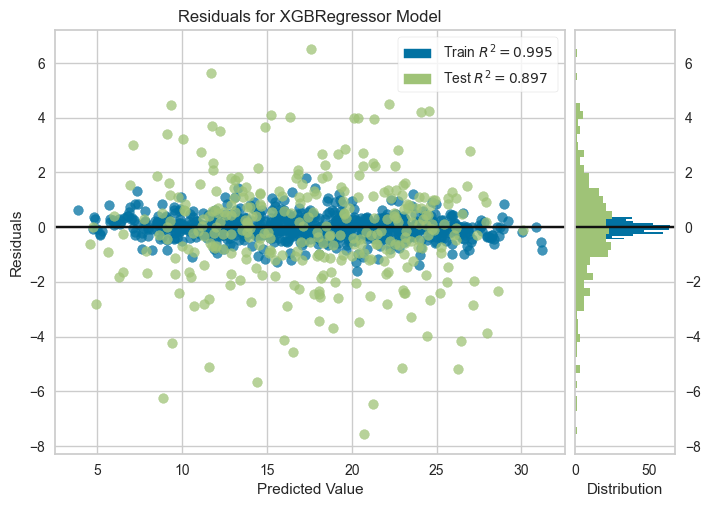

In [49]:
plot_model(xg_tuned, plot = 'residuals')

In [50]:
predictions = predict_model(xg_tuned, data=data_unseen)

#### CatBoost

In [51]:
cat = create_model('catboost')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

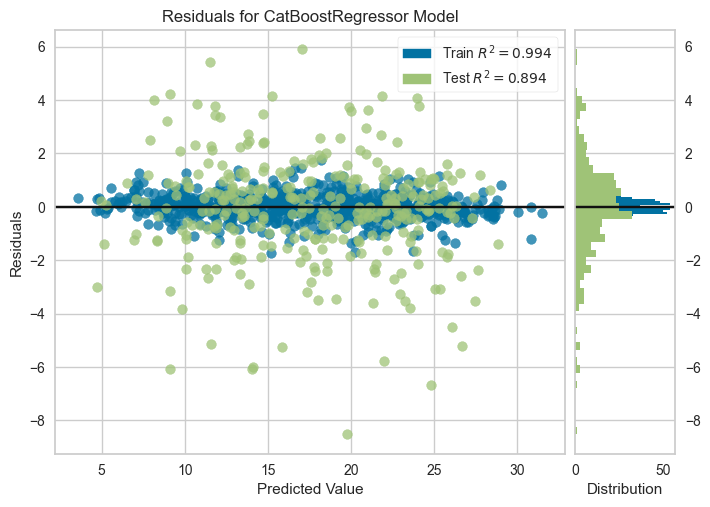

In [52]:
plot_model(cat, plot = 'residuals')

In [53]:
param_grid_cat = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [3, 4, 5, 6, 7, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],  
    'bagging_temperature': [0.2, 0.5, 0.8, 1.0],  
    'border_count': [32, 64, 128, 255],  
    'iterations': [50, 100, 200, 300,500,700,1000],  
    'loss_function': ['RMSE', 'Logloss', 'MultiClass'],  
    'random_strength': [0.5, 1, 2, 3],  
    'boosting_type': ['Ordered', 'Plain'],  
    'subsample': [0.5, 0.7, 0.9, 1.0],  
    'rsm': [0.5, 0.7, 0.9, 1.0],  
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'] 
}

In [54]:
cat_tuned = tune_model(
    cat,
    fold = 10,
    n_iter = 100,
    custom_grid = param_grid_cat,
    choose_better = False,
    optimize='R2'
)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


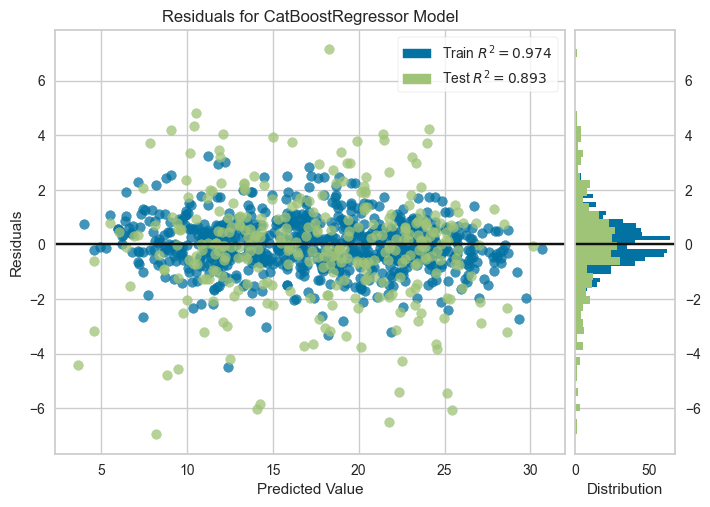

In [55]:
plot_model(cat_tuned, plot = 'residuals')

In [56]:
predict_model(cat_tuned, data=data_unseen)

start_year  end_year  rr?  overhead?  anglo    train_type project_type  \
10          2011      2016  0.0          0      0           MRT          New   
14          1975      1980  0.0          0      0           MRT          New   
16          2012      2022  1.0          0      0           MRT    Extension   
24          2007      2011  0.0          1      0     Streetcar          New   
25          2007      2013  0.0          0      0           MRT    Extension   
...          ...       ...  ...        ...    ...           ...          ...   
1567        2010      2013  0.0          1      0     Streetcar          New   
1572        2004      2006  0.0          1      0     Streetcar          New   
1575        2008      2013  0.0          1      0     Streetcar    Extension   
1580        2007      2010  0.0          0      0  Monorail/APM          New   
1602        2015      2018  0.0          1      0     Streetcar    Extension   

      region       sub_region  wrb_class_value  ...  stations_transformed  \
10      Asia     Eastern Asia              0.0  ...              2.194834   
14      Asia     Eastern Asia              0.0  ...              3.815913   
16      Asia     Eastern Asia              0.0  ...              2.995571   
24    Europe   Western Europe              7.0  ...              1.620124   
25      Asia     Eastern Asia             18.0  ...              2.427092   
...      ...              ...              ...  ...                   ...   
1567  Europe   Western Europe              6.0  ...              5.053986   
1572  Europe   Western Europe              6.0  ...              4.236001   
1575  Europe   Western Europe              6.0  ...              5.384559   
1580  Europe  Southern Europe              6.0  ...              1.620124   
1602  Europe   Western Europe             18.0  ...              4.330624   

      population_transformed  calculated_population_transformed  \
10                142.824142                         154.365875   
14                142.824142                         147.529846   
16                142.824142                         154.949234   
24                127.192993                         137.726166   
25                183.104080                         191.715942   
...                      ...                                ...   
1567               56.692493                          59.531315   
1572               43.014122                          44.846031   
1575               57.719742                          60.716995   
1580               66.022018                          70.561546   
1602               55.667015                          58.715710   

      per_below_line_transformed  max_speed_transformed  \
10                      4.006754              34.708786   
14                      4.813365              34.708786   
16                      3.243397              34.708786   
24                      0.187411              24.138018   
25                      4.424350              41.199310   
...                          ...                    ...   
1567                    0.188472              20.290298   
1572                    0.219368              20.290298   
1575                    0.188472              20.290298   
1580                    0.968170              20.290298   
1602                    0.216166              24.138018   

      reporting_gdp_transformed  prcp_transformed  track_gauge_transformed  \
10                    21.653063         19.287930             6.241706e+06   
14                    11.772905         19.287930             6.212213e+06   
16                    24.587807         19.287930             6.241706e+06   
24                    34.889629          9.693435             6.241706e+06   
25                    21.653063          9.660558             6.241706e+06   
...                         ...               ...                      ...   
1567                  34.701347         10.512624           

#### Huber Regressor

In [57]:
hub = create_model('huber')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

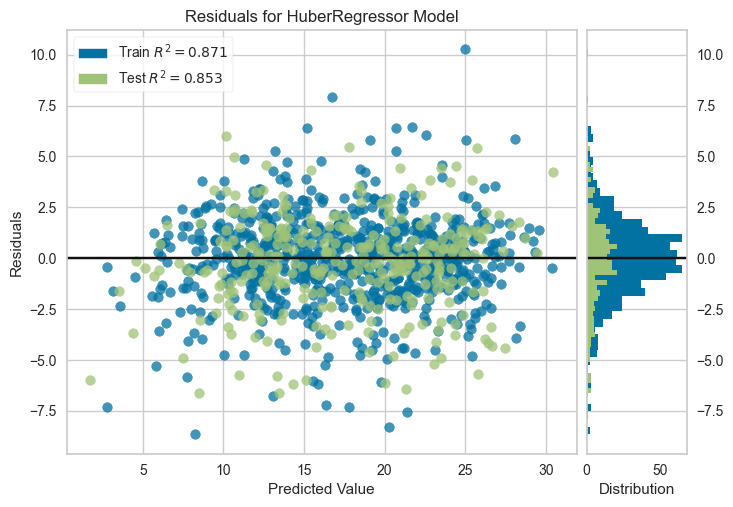

In [58]:
plot_model(hub, plot = 'residuals')

In [59]:
param_grid_hub = {
    'epsilon': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5],  # Epsilon parameter determines the threshold at which it becomes less sensitive to outliers.
    'max_iter': [50, 100, 150, 200], 
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'fit_intercept': [True, False],  # Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
    'warm_start': [True, False],  # Reuse the solution of the previous call to fit as initialization
    'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]  # Tolerance for stopping criteria
}

In [60]:
hub_tuned = tune_model(
    hub,
    fold = 10,
    n_iter = 100,
    custom_grid = param_grid_hub,
    choose_better = False,
    optimize='R2'
)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


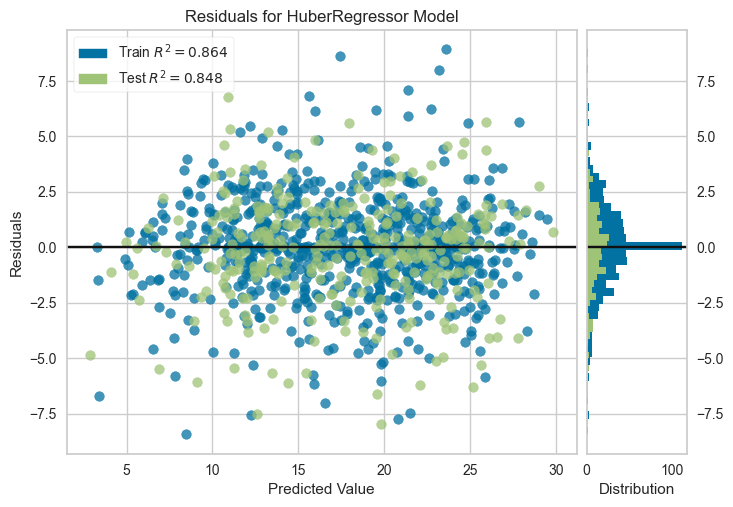

In [61]:
plot_model(hub_tuned, plot = 'residuals')

In [62]:
predictions = predict_model(hub_tuned, data=data_unseen)

### LightGBM

In [63]:
light = create_model('lightgbm')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

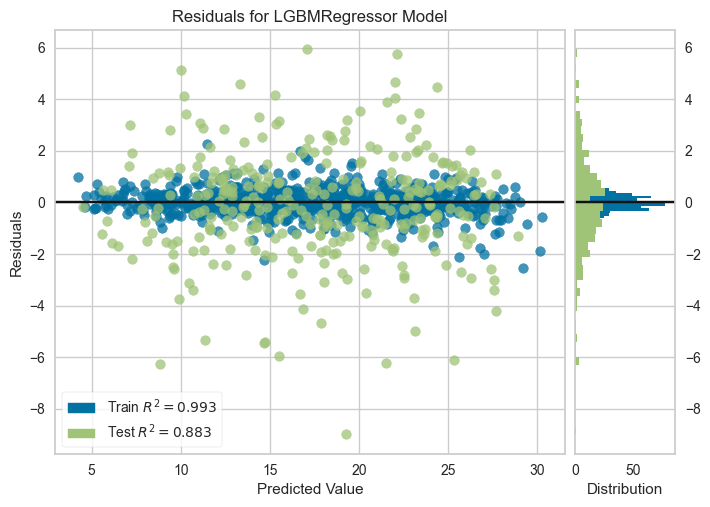

In [64]:
plot_model(light, plot = 'residuals')

In [65]:
param_grid_light = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 62, 127, 255],
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'n_estimators': [50, 100, 200, 300],
    'objective': ['regression', 'binary', 'multiclass'],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0, 0.5, 1],
    'boosting_type': ['gbdt', 'dart', 'goss']
}

In [66]:
light_tuned = tune_model(
    light,
    fold = 10,
    n_iter = 50,
    custom_grid = param_grid_light,
    choose_better = False,
    optimize='R2'
)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2696
[LightGBM] [Info] Number of data points in the train set: 666, number of used features: 69
[LightGBM] [Info] Start training from score 17.510065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 666, number of negative: 0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2697
[LightGBM] [Info] Number of data points in the train set: 666, number of used features: 69
[LightGBM] [Info] Using GOSS
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2723
[LightGBM] [Info] Number of data points in the train set: 666, number of used features: 69
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 17.470149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2707
[LightGBM] [Info] Number of data points in the train set: 666, number of used features: 69
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stoppe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the train set:

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the train set: 666, number of used features: 69
[LightGBM] [Info] Start training from score 17.643038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

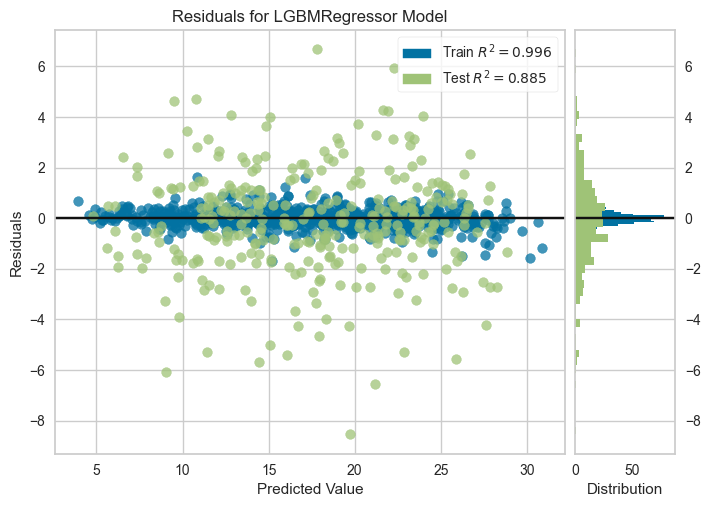

In [67]:
plot_model(light_tuned, plot = 'residuals')

In [68]:
predictions = predict_model(light_tuned, data=data_unseen)

### Gradient Boost

In [69]:
gbr = create_model('gbr')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

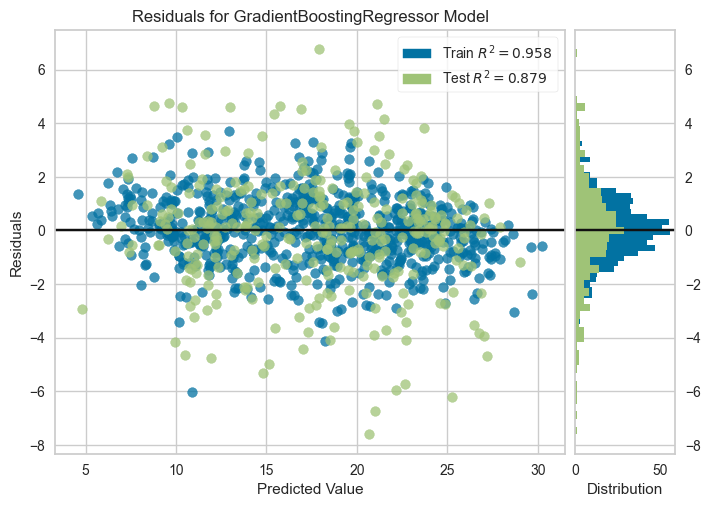

In [70]:
plot_model(gbr, plot = 'residuals')

In [71]:
param_grid_gbr = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'n_estimators': [50, 100, 200, 300,400,500,600,700,800,900,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'alpha': [0.5, 0.75, 0.9]
}

In [72]:
gbr_tuned = tune_model(
    gbr,
    fold = 10,
    n_iter = 100,
    custom_grid = param_grid_gbr,
    choose_better = False,
    optimize='R2'
)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


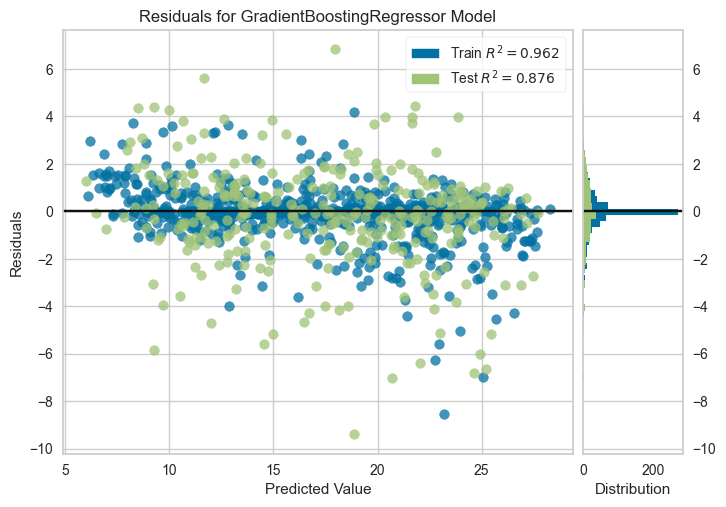

In [73]:
plot_model(gbr_tuned, plot = 'residuals')

In [74]:
predictions = predict_model(gbr_tuned, data=data_unseen)

### Bagging

In each of the tuned models, including the 'final' model, the variance in the residuals plots are higher than I'd like (and overfitting in the learning curves). To combat this, I'd like to bag the tuned models individually.

#### Huber

In [75]:
hub_bagged = ensemble_model(hub_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True, optimize='R2')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


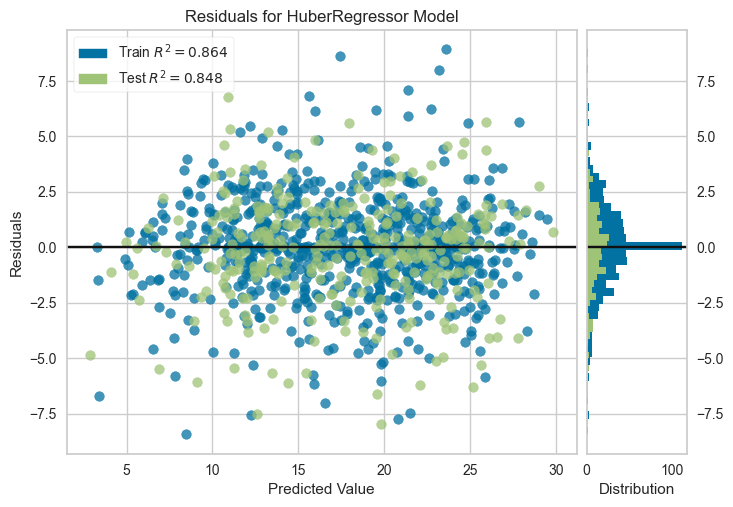

In [76]:
plot_model(hub_bagged, plot = 'residuals')

#### Random Forest

In [77]:
rf_bagged = ensemble_model(rf_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True, optimize='R2')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2714
[LightGBM] [Info] Number of data points in the train set: 666, number of used features: 69
[LightGBM] [Info] Start training from sco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


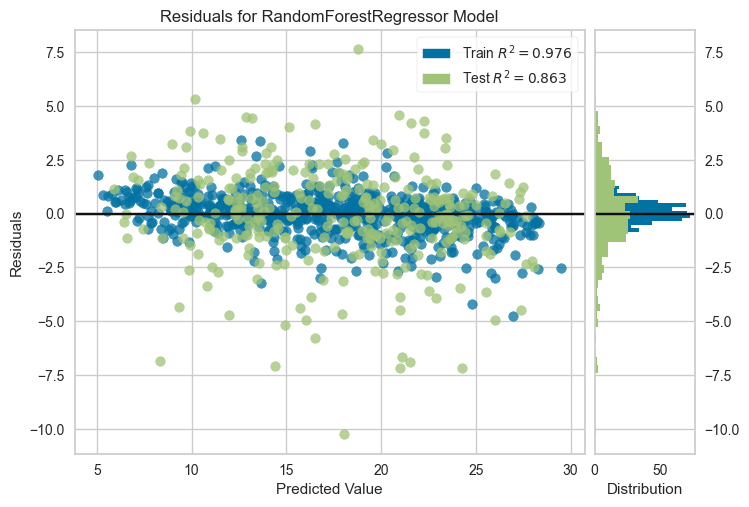

In [78]:
plot_model(rf_bagged, plot = 'residuals')

#### Bayesian Ridge

In [79]:
br_bagged = ensemble_model(br_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True, optimize='R2')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

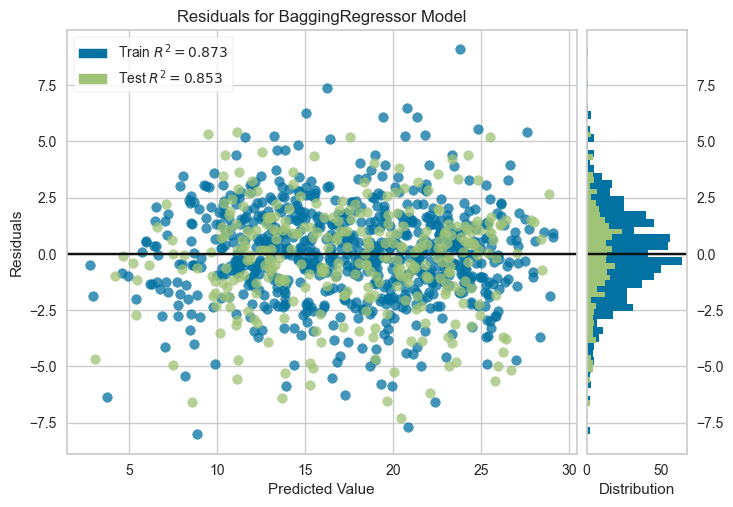

In [80]:
plot_model(br_bagged, plot = 'residuals')

The tuned model returned an R-squared on the residuals plot of .842/.769 (train/test). The bagged version of the tuned br returned a slightly lower MAE and lower mean R-squared.

#### Extra Trees

In [81]:
et_bagged = ensemble_model(et_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True, optimize='R2')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


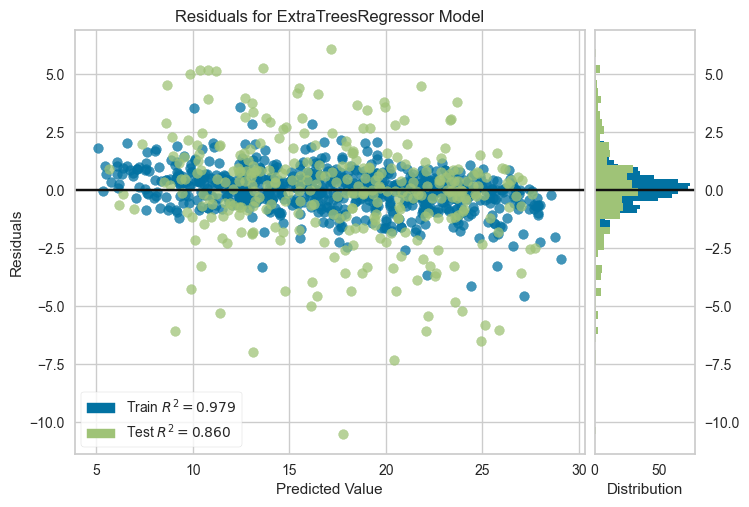

In [82]:
plot_model(et_bagged, plot = 'residuals')

#### Elastic Net

In [83]:
en_bagged = ensemble_model(en_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True, optimize='R2')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

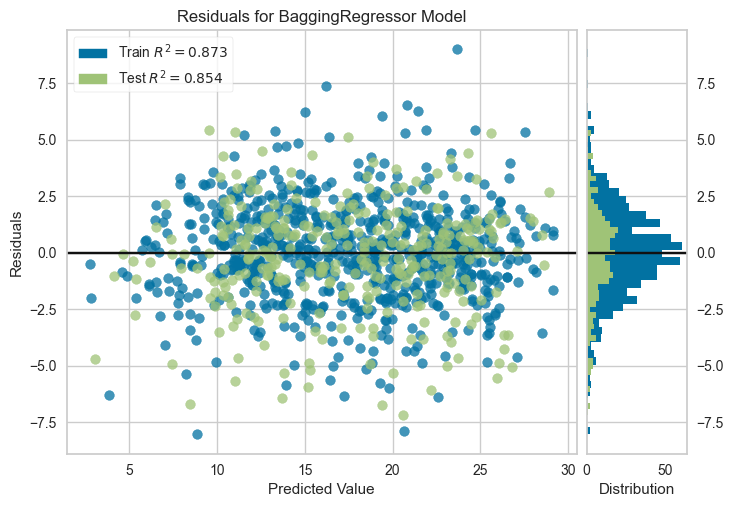

In [84]:
plot_model(en_bagged, plot = 'residuals')

#### XGBoost

In [85]:
xg_bagged = ensemble_model(xg_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True, optimize='MAPE')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


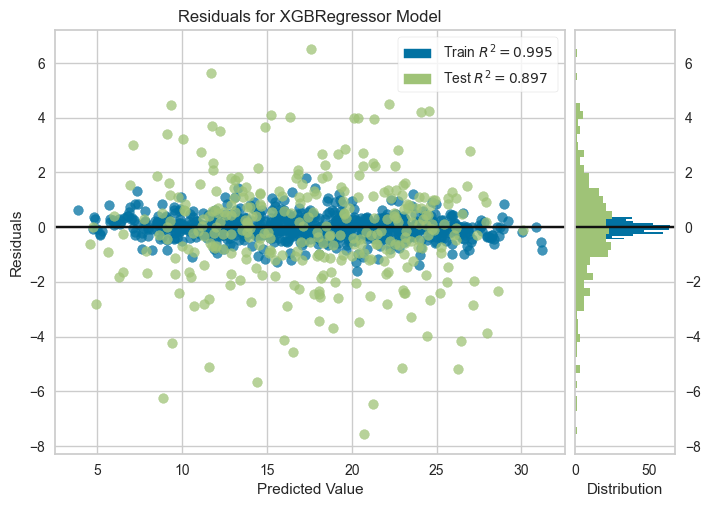

In [86]:
plot_model(xg_bagged, plot = 'residuals')

#### CatBoost

For some reason bagging the catboost regressor raises an error.

In [87]:
cat_bagged = cat_tuned

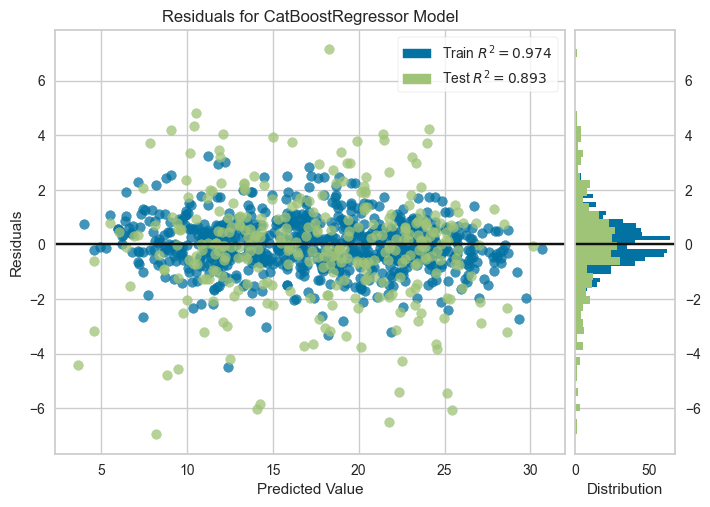

In [88]:
plot_model(cat_bagged, plot = 'residuals')

#### LightGBM

In [89]:
light_bagged = ensemble_model(light_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True, optimize='MAPE')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


Notably, LightGBM takes significantly longer to model, which would be an issue if the model were to become any larger. Model performance is multifaceted and modelling time is one facet of note.

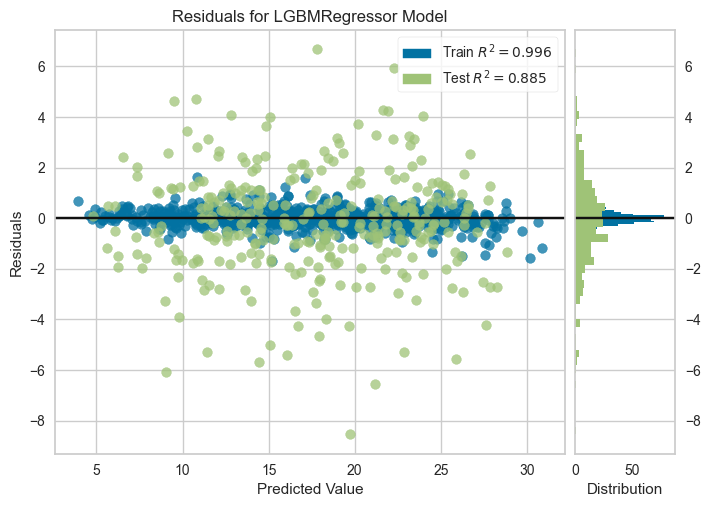

In [90]:
plot_model(light_bagged, plot = 'residuals')

#### GradientBoost

In [91]:
gbr_bagged = ensemble_model(gbr_tuned,method = 'Bagging',fold = 10,n_estimators = 100, choose_better = True, optimize='MAPE')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


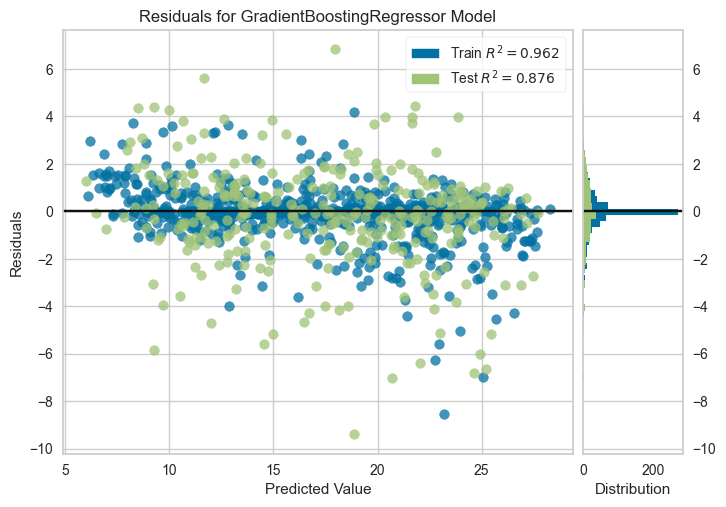

In [92]:
plot_model(gbr_bagged, plot = 'residuals')

### Which Individual Models Performed Best

Best is, ostensibly, somewhat of a judgement rather than a science. I'm looking to optimize for low test MAE and high test R-squared.

From the bagged models, it appears that CatBoost, LightGBM, XGBoost, and ExtraTrees performed the best.

In [93]:
predictions_light = predict_model(light_bagged, data=data_unseen)
predictions_cat = predict_model(cat_bagged, data=data_unseen)
predictions_xgb = predict_model(xg_bagged, data=data_unseen)
predictions_et = predict_model(et_bagged, data=data_unseen)
predictions_rf = predict_model(rf_bagged, data=data_unseen)
predictions_en = predict_model(en_bagged, data=data_unseen)
predictions_hub = predict_model(hub_bagged, data=data_unseen)
predictions_br = predict_model(br_bagged, data=data_unseen)

The above predictions are on un-seen data and provide insight into how well each model interprets the trends in the data. Once the final model is chosen, the selected model will then be trained on all of the data (data + un-seen data), which should improve the performance.

Based on these preliminary predictions, each model is relatively close in terms of performance. The LightGBM model performed slightly better in terms of MAE, but slightly worse in terms of R-squared, in comparison to the Extra Trees model.

The next step will be to blend several of these models together to create a diverse and unique algorithm.

### Blending

Now that I've tuned the individual models, I'll blend the best models together to identify if the model produced by blending can out-perform any single model.

It's worth noting that the Gradient Boosting frameworks performed the best on the data. Since the purpose of blending it to create a diverse model comprised of several distinct models, it wouldn't likely be advantageous to blend several of the GBMs together. I'll need to incorporate other model types to create the diverse model I'm after.

Both XGBoost and LightGBM have built-in L1/L2 regularization, so a model like a Baysian Ridge or an Elastic Net may not provide as much diversity as normally expected.

I'll start with the best tree based model, along with the best gradient boosted model.

In [94]:
models = [cat_bagged, xg_bagged,light_bagged]

In [95]:
blended = blend_models(models, optimize='MAPE')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [96]:
predictions_blend = predict_model(blended, data=data_unseen)

In [97]:
plot_model(blended, plot='learning')

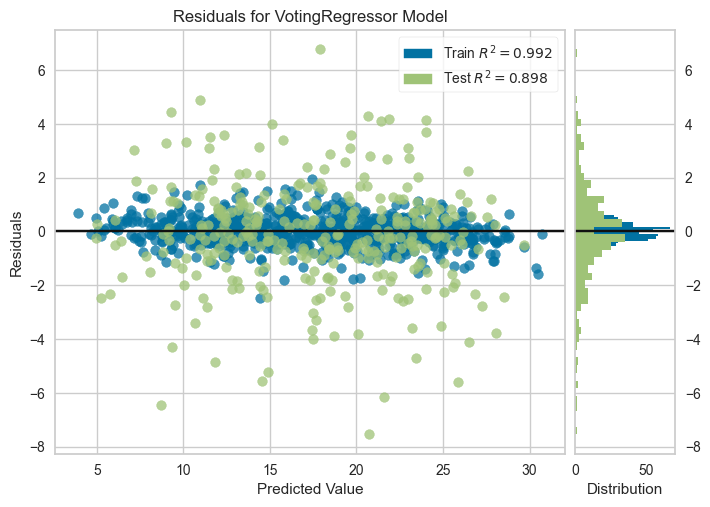

In [98]:
plot_model(blended, plot = 'residuals')

The 'base blended' model achieves both a better MAE and R-squared on the un-seen data and the training data. Let's tune the weights of the blended model.

In [99]:
models = [cat_bagged, xg_bagged]

In [100]:
blended_tuned = blend_models(models, weights = [.6,.4], optimize='RMSE')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Tuning the weights of the blended model takes approximately 12 hours when the bagged LightGBM model is included. This is prohibitive and so I'll approximate the tuning process myself using the tuned lightgbm.

In [101]:
predictions_blend_tuned = predict_model(blended_tuned, data=data_unseen)

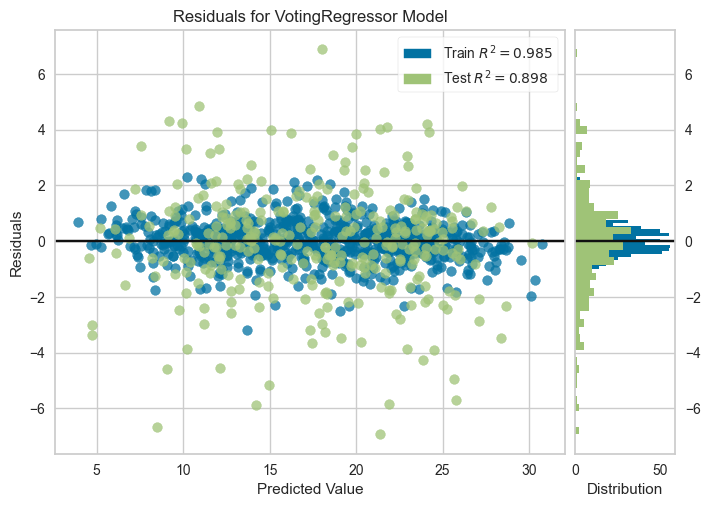

In [102]:
plot_model(blended_tuned, plot = 'residuals')

The tuned blended model fared slightly better on unseen data and is less overfit.

### Summary of Progress

In [103]:
best_model_preds = predict_model(cat, data=data_unseen)
tuned_best_preds = predict_model(cat_tuned, data=data_unseen)
bagged_best_preds = predict_model(cat_tuned, data=data_unseen)
blended_model_preds= predict_model(blended, data=data_unseen)
blended_tuned_preds= predict_model(blended_tuned, data=data_unseen)

As you can see the base model resulted in the lowest MAE, however it doesn't generalize as well to new data. The blended and tuned model will be passed to the next steps.

### Summary of Models

In [104]:
model_results = [
    {'Model': 'CatBoost Regressor', 'MAE': 1.4147, 'MSE': 4.0962, 'RMSE': 2.0239, 'R2': 0.8763, 'RMSLE': 0.1302, 'MAPE': 0.0960},
    {'Model': 'CatBoost Regressor', 'MAE': 1.4416, 'MSE': 4.3300, 'RMSE': 2.0809, 'R2': 0.8692, 'RMSLE': 0.1359, 'MAPE': 0.0988},
    {'Model': 'CatBoost Regressor', 'MAE': 1.4416, 'MSE': 4.3300, 'RMSE': 2.0809, 'R2': 0.8692, 'RMSLE': 0.1359, 'MAPE': 0.0988},
    {'Model': 'Voting Regressor', 'MAE': 1.4063, 'MSE': 4.0803, 'RMSE': 2.0200, 'R2': 0.8767, 'RMSLE': 0.1285, 'MAPE': 0.0948},
    {'Model': 'Voting Regressor', 'MAE': 1.4066, 'MSE': 4.1419, 'RMSE': 2.0352, 'R2': 0.8749, 'RMSLE': 0.1311, 'MAPE': 0.0956}
]

model_naming = [
    ('CatBoost Base (After 1st Pass Outlier Removal)', 'M_B1', 'df_adj'),
    ('CatBoost Tuned', 'M_B2', 'df_adj'),
    ('CatBoost Bagged', 'M_B3', 'df_adj'),
    ('Blended', 'M_B4', 'df_adj'),
    ('Blended & Tuned', 'M_B5', 'df_adj')
]

data_summary = {
    'Model': [name for name, _, _ in model_naming],
    'Version': [version for _, version, _ in model_naming],
    'Dataset': [dataset for _, _, dataset in model_naming],
    'MAE': [result['MAE'] for result in model_results],
    'MSE': [result['MSE'] for result in model_results],
    'RMSE': [result['RMSE'] for result in model_results],
    'R2': [result['R2'] for result in model_results],
    'RMSLE': [result['RMSLE'] for result in model_results],
    'MAPE': [result['MAPE'] for result in model_results]
}

combined_metrics_base = pd.DataFrame(data_summary)
combined_metrics_base

Model Version Dataset     MAE  \
0  CatBoost Base (After 1st Pass Outlier Removal)    M_B1  df_adj  1.4147   
1                                  CatBoost Tuned    M_B2  df_adj  1.4416   
2                                 CatBoost Bagged    M_B3  df_adj  1.4416   
3                                         Blended    M_B4  df_adj  1.4063   
4                                 Blended & Tuned    M_B5  df_adj  1.4066   

      MSE    RMSE      R2   RMSLE    MAPE  
0  4.0962  2.0239  0.8763  0.1302  0.0960  
1  4.3300  2.0809  0.8692  0.1359  0.0988  
2  4.3300  2.0809  0.8692  0.1359  0.0988  
3  4.0803  2.0200  0.8767  0.1285  0.0948  
4  4.1419  2.0352  0.8749  0.1311  0.0956

In [105]:
combined_metrics = combined_metrics.append(combined_metrics_base, ignore_index=True)

In [106]:
combined_metrics

Model Version  Dataset     MAE  \
0                                Model First Pass    M_A1  Base df  1.5320   
1  CatBoost Base (After 1st Pass Outlier Removal)    M_B1   df_adj  1.4147   
2                                  CatBoost Tuned    M_B2   df_adj  1.4416   
3                                 CatBoost Bagged    M_B3   df_adj  1.4416   
4                                         Blended    M_B4   df_adj  1.4063   
5                                 Blended & Tuned    M_B5   df_adj  1.4066   

      MSE    RMSE      R2   RMSLE    MAPE  
0  4.8763  2.2082  0.8737  0.1459  0.1133  
1  4.0962  2.0239  0.8763  0.1302  0.0960  
2  4.3300  2.0809  0.8692  0.1359  0.0988  
3  4.3300  2.0809  0.8692  0.1359  0.0988  
4  4.0803  2.0200  0.8767  0.1285  0.0948  
5  4.1419  2.0352  0.8749  0.1311  0.0956

The four iterations of the model returned the results, as summarized above. The best iteration of the model was the blended and bagged model, before tuning.

### Finalized Model

In [107]:
finalized_best = finalize_model(blended_tuned)

In [108]:
predictions = predict_model(finalized_best, data=data_unseen)

In [109]:
predictions

start_year  end_year  rr?  overhead?  anglo    train_type project_type  \
10          2011      2016  0.0          0      0           MRT          New   
14          1975      1980  0.0          0      0           MRT          New   
16          2012      2022  1.0          0      0           MRT    Extension   
24          2007      2011  0.0          1      0     Streetcar          New   
25          2007      2013  0.0          0      0           MRT    Extension   
...          ...       ...  ...        ...    ...           ...          ...   
1567        2010      2013  0.0          1      0     Streetcar          New   
1572        2004      2006  0.0          1      0     Streetcar          New   
1575        2008      2013  0.0          1      0     Streetcar    Extension   
1580        2007      2010  0.0          0      0  Monorail/APM          New   
1602        2015      2018  0.0          1      0     Streetcar    Extension   

      region       sub_region  wrb_class_value  ...  stations_transformed  \
10      Asia     Eastern Asia              0.0  ...              2.194834   
14      Asia     Eastern Asia              0.0  ...              3.815913   
16      Asia     Eastern Asia              0.0  ...              2.995571   
24    Europe   Western Europe              7.0  ...              1.620124   
25      Asia     Eastern Asia             18.0  ...              2.427092   
...      ...              ...              ...  ...                   ...   
1567  Europe   Western Europe              6.0  ...              5.053986   
1572  Europe   Western Europe              6.0  ...              4.236001   
1575  Europe   Western Europe              6.0  ...              5.384559   
1580  Europe  Southern Europe              6.0  ...              1.620124   
1602  Europe   Western Europe             18.0  ...              4.330624   

      population_transformed  calculated_population_transformed  \
10                142.824142                         154.365875   
14                142.824142                         147.529846   
16                142.824142                         154.949234   
24                127.192993                         137.726166   
25                183.104080                         191.715942   
...                      ...                                ...   
1567               56.692493                          59.531315   
1572               43.014122                          44.846031   
1575               57.719742                          60.716995   
1580               66.022018                          70.561546   
1602               55.667015                          58.715710   

      per_below_line_transformed  max_speed_transformed  \
10                      4.006754              34.708786   
14                      4.813365              34.708786   
16                      3.243397              34.708786   
24                      0.187411              24.138018   
25                      4.424350              41.199310   
...                          ...                    ...   
1567                    0.188472              20.290298   
1572                    0.219368              20.290298   
1575                    0.188472              20.290298   
1580                    0.968170              20.290298   
1602                    0.216166              24.138018   

      reporting_gdp_transformed  prcp_transformed  track_gauge_transformed  \
10                    21.653063         19.287930             6.241706e+06   
14                    11.772905         19.287930             6.212213e+06   
16                    24.587807         19.287930             6.241706e+06   
24                    34.889629          9.693435             6.241706e+06   
25                    21.653063          9.660558             6.241706e+06   
...                         ...               ...                      ...   
1567                  34.701347         10.512624           

### Section Summary / Next Steps

Now that I've modelled the data using every feature, I'd like to decrease the model variance that is displayed in the learning curves. To do this, I'll need to evaluate which features to include in the final model (feature reduction). I'll also determine if there's additional features I can engineer or if several features can be combined to create a more valuable feature for the model.

### Exports

In [112]:
with open('pickles/combined_metrics.pkl', 'wb') as f:
    pickle.dump(combined_metrics, f)

In [113]:
with open('pickles/et_tuned.pkl', 'wb') as f:
    pickle.dump(et_tuned, f)    
with open('pickles/hub.pkl', 'wb') as f:
    pickle.dump(hub, f)
with open('pickles/xg.pkl', 'wb') as f:
    pickle.dump(xg, f)
with open('pickles/light.pkl', 'wb') as f:
    pickle.dump(light, f)

In [114]:
with open('pickles/data.pkl', 'wb') as f:
    pickle.dump(data, f)
with open('pickles/data_unseen.pkl', 'wb') as f:
    pickle.dump(data_unseen, f) 
with open('pickles/df_model.pkl', 'wb') as f:
    pickle.dump(df_model, f)
with open('pickles/predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [115]:
save_model(blended, 'blended')
save_model(blended_tuned, 'blended_tuned')
save_model(finalized_best, 'finalized_best')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['start_year', 'end_year', 'rr?',
                                              'overhead?', 'anglo',
                                              'prob_Ferralsols', 'prob_Acrisols',
                                              'prob_Andosols', 'prob_Cryosols',
                                              'prob_Cambisols', 'prob_Gleysols',
                                              'prob_Kastanozems',
                                              'prob_Albeluvisols',
                                              'prob_Calcisols',
                                              'prob_Chernozems', 'prob_Durisols',
                                              'prob_Gypsisols',...
                                                            importance_type=None,
                                                            interaction_constraints=None,
             